In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")



In [2]:
pd.options.display.max_columns=100 # to see columns


In [3]:
df_store = pd.read_csv('stores.csv') #store data

In [4]:
df_train = pd.read_csv('train.csv') # train set

In [5]:
df_features = pd.read_csv('features.csv') #external information

In [6]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [10]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [11]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [12]:
df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [13]:
df.shape

(421570, 16)

In [14]:
df['Store'].nunique() # number of different values

45

In [15]:
df['Dept'].nunique() # number of different values

81

In [16]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

In [17]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [18]:
df = df.loc[df['Weekly_Sales'] > 0]

In [19]:
df.shape

(420212, 16)

In [20]:
df['Date'].head(5)

0    2010-02-05
1    2010-02-05
2    2010-02-05
3    2010-02-05
4    2010-02-05
Name: Date, dtype: object

In [21]:
df['Date'].tail(5) 

421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

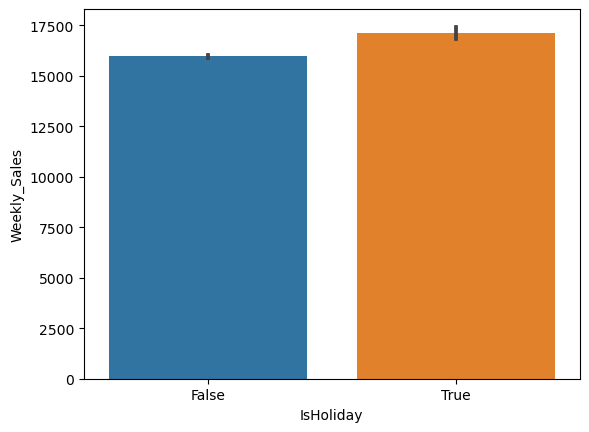

In [22]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [23]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [24]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

In [25]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [26]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [27]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [28]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

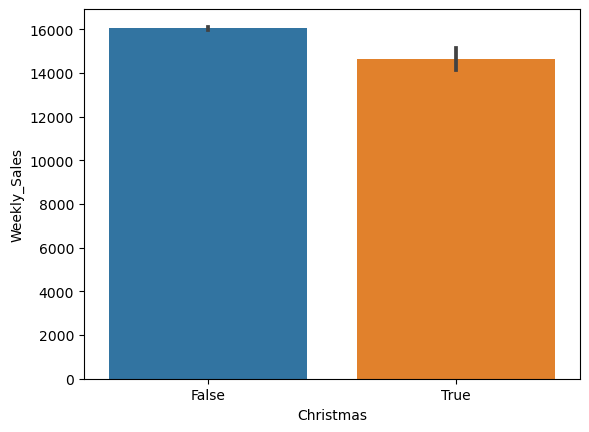

In [29]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

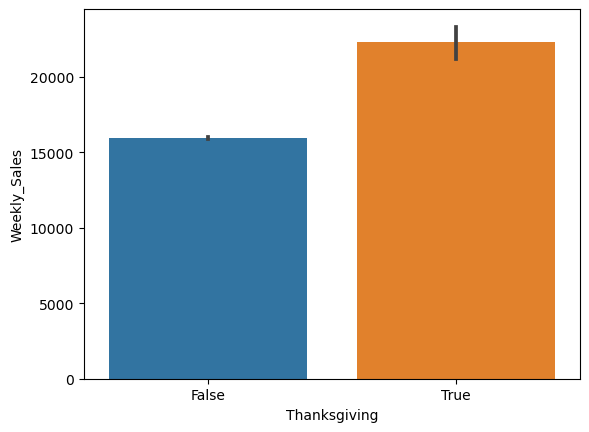

In [30]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

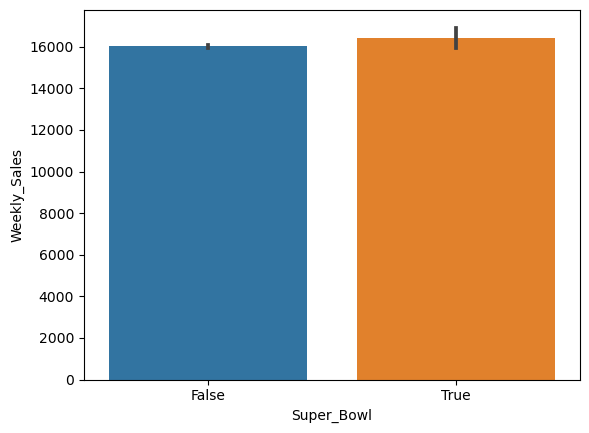

In [31]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<AxesSubplot:xlabel='Labor_Day', ylabel='Weekly_Sales'>

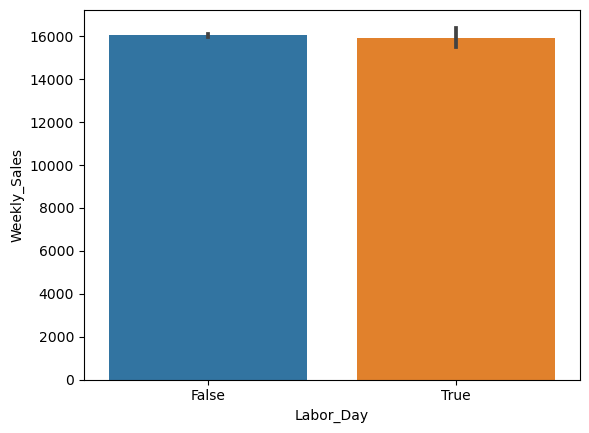

In [32]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

In [33]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [34]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [35]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [36]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

In [37]:
total_data=len(df['Type'])

In [38]:
total_data

420212

In [39]:
# Calculate the proportion
prop_A = (df['Type'] == 'A').sum() / total_data*100


In [40]:
prop_A

51.155369194597014

In [41]:
prop_B=(df['Type'] == 'B').sum() / total_data*100

In [42]:
prop_B

38.739255423452924

In [43]:
prop_C=(df['Type'] == 'C').sum() / total_data*100

In [44]:
prop_C

10.105375381950063

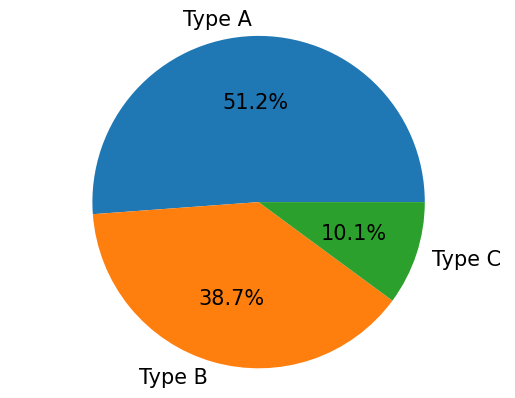

In [45]:
my_data = [51.15, 38.73 , 10.10 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [46]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

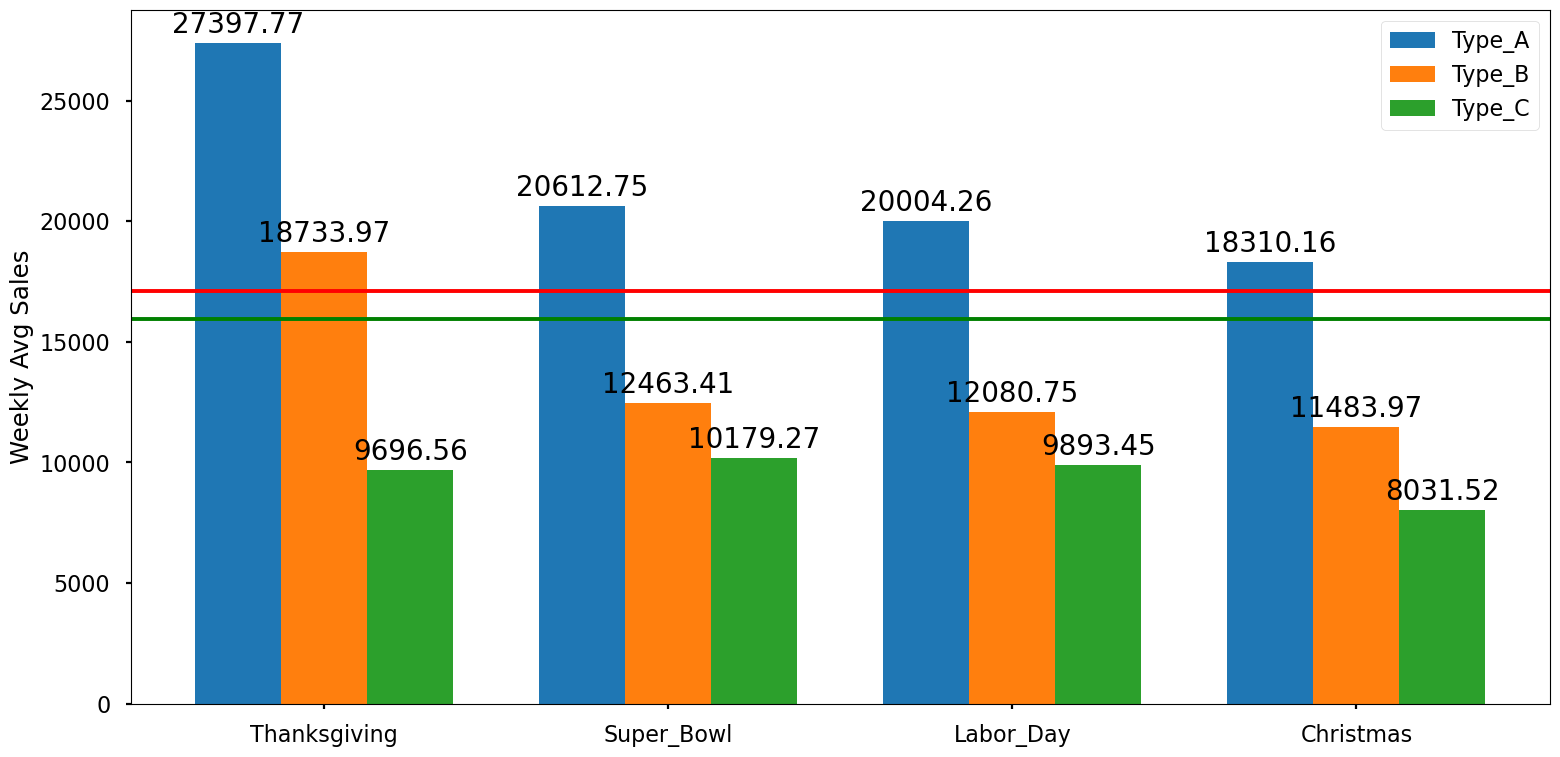

In [47]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

In [48]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


In [49]:
df_store.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


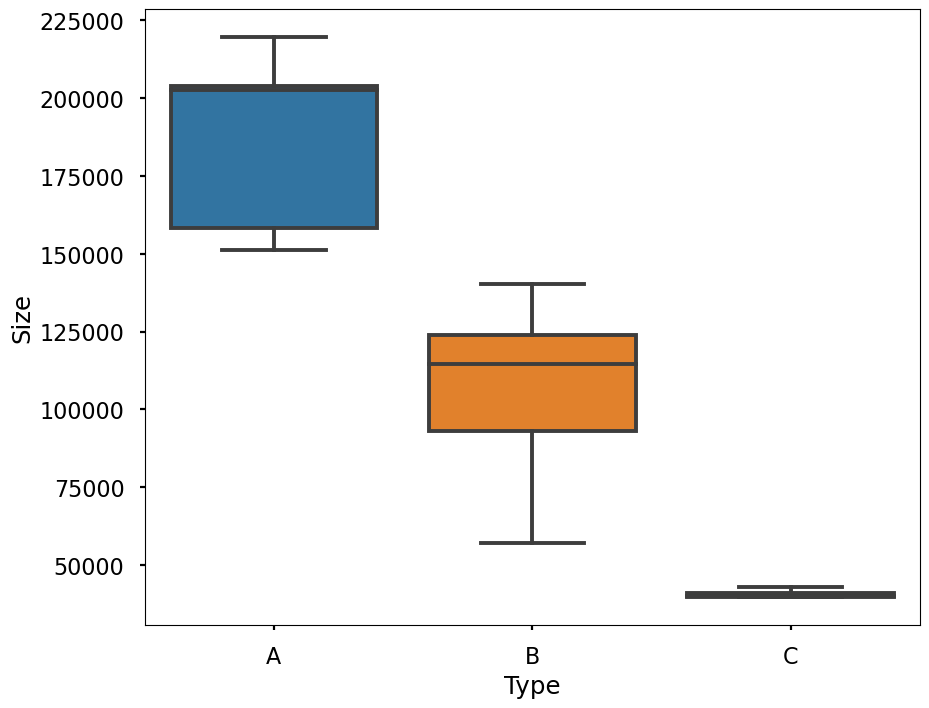

In [50]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

In [51]:
df.isnull().sum()


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [52]:
df = df.fillna(0)

In [53]:
df.isna().sum() # last null check

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [54]:
df.describe() # to see weird statistical things

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


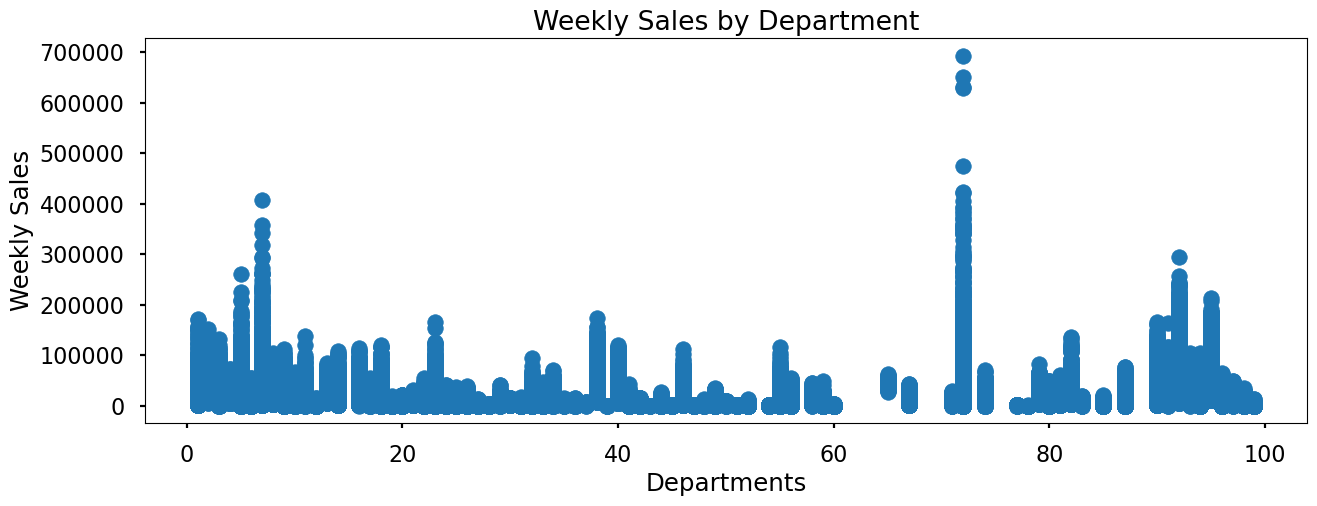

In [55]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

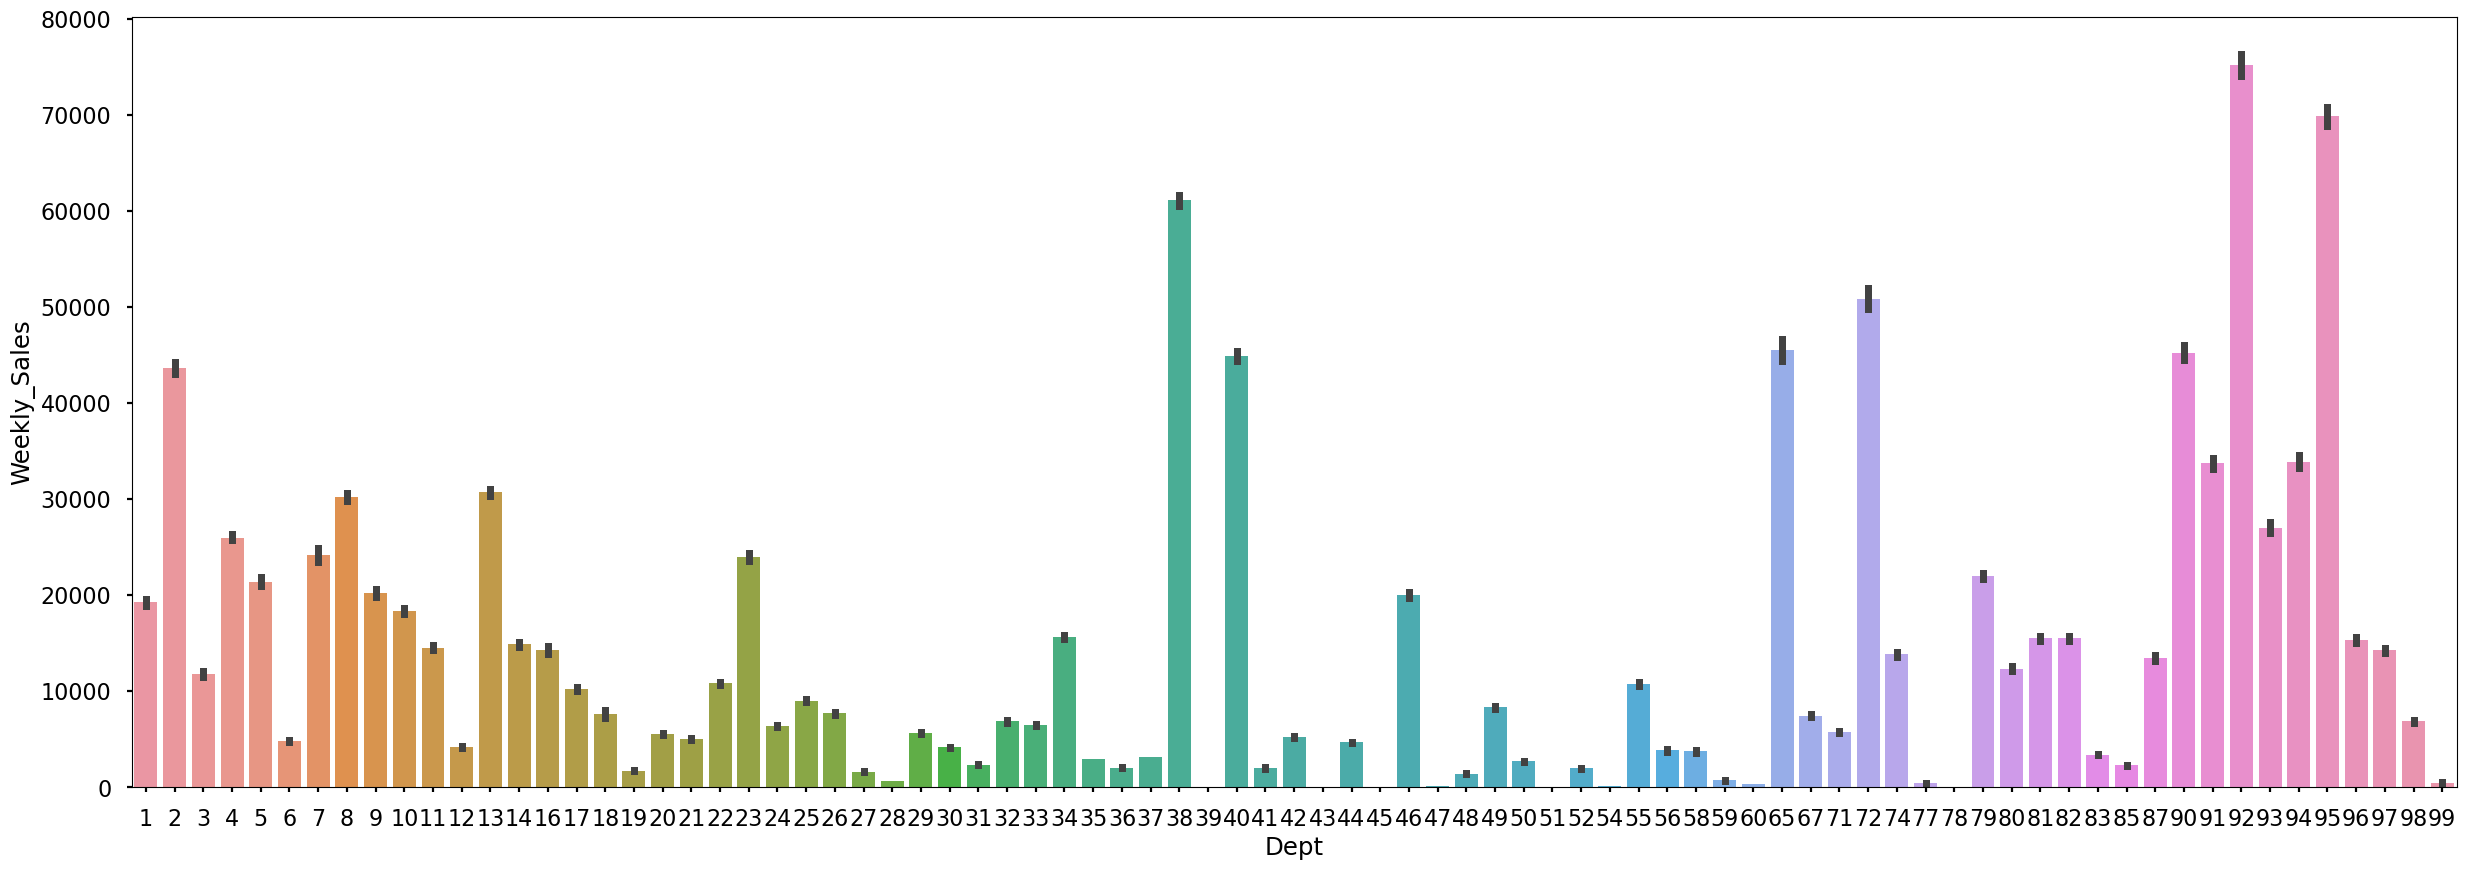

In [56]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

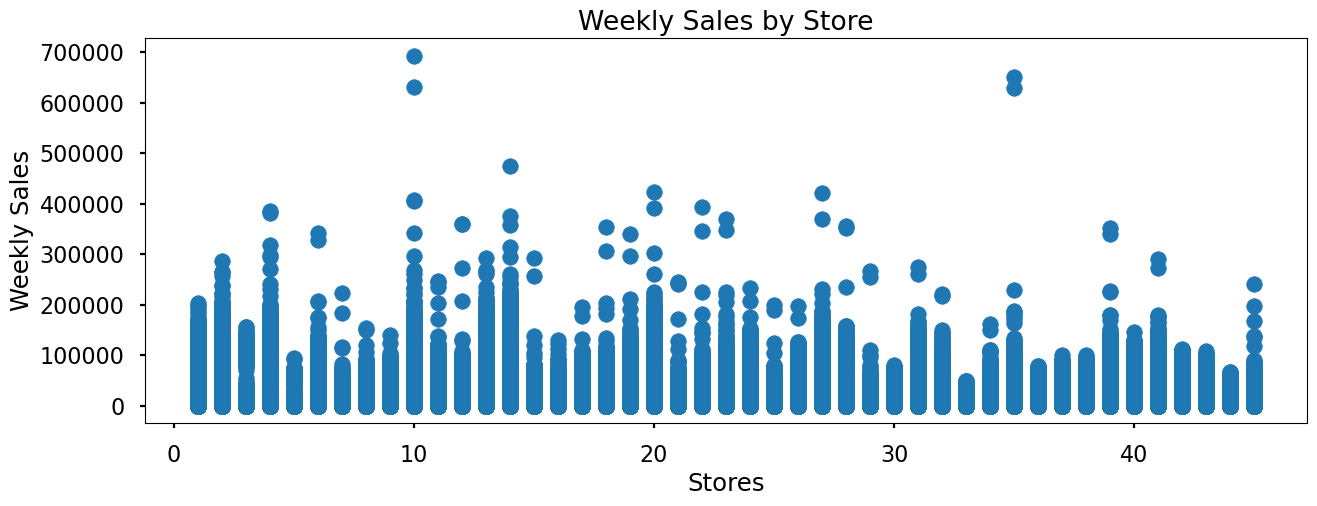

In [57]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

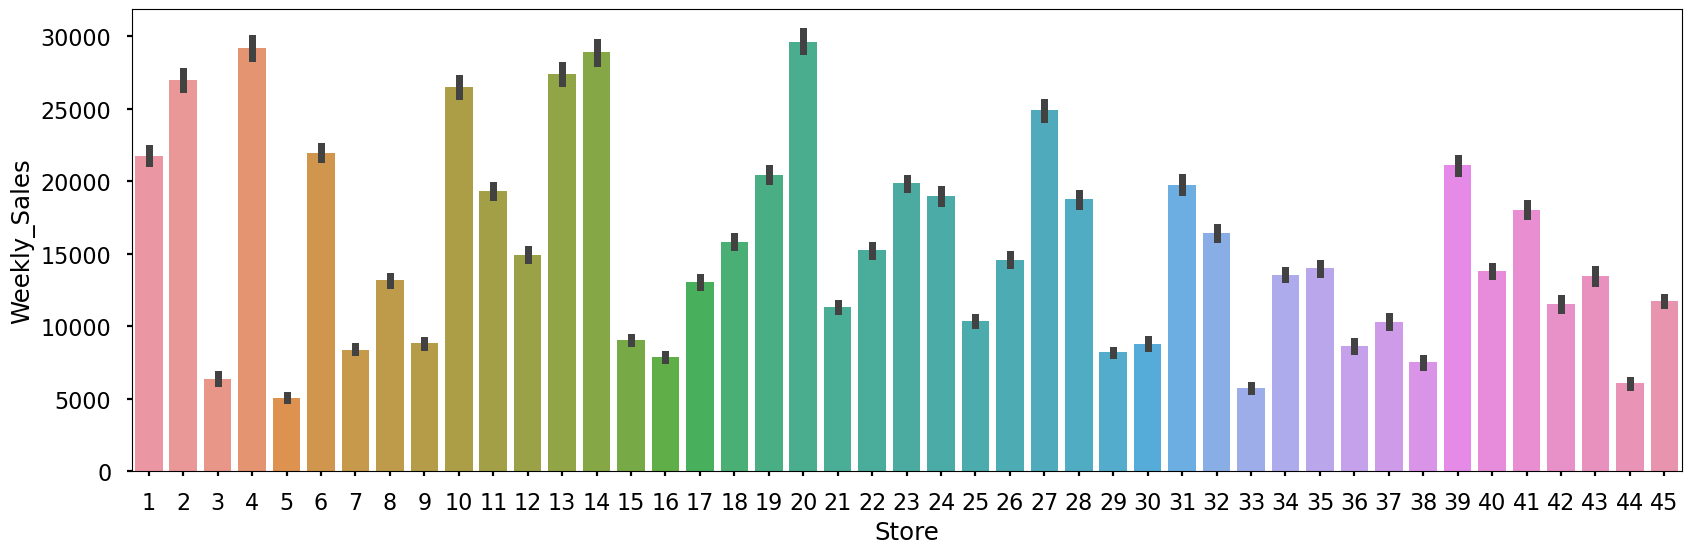

In [58]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

In [59]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] = df['Date'].dt.isocalendar().week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

In [60]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [61]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='month'>

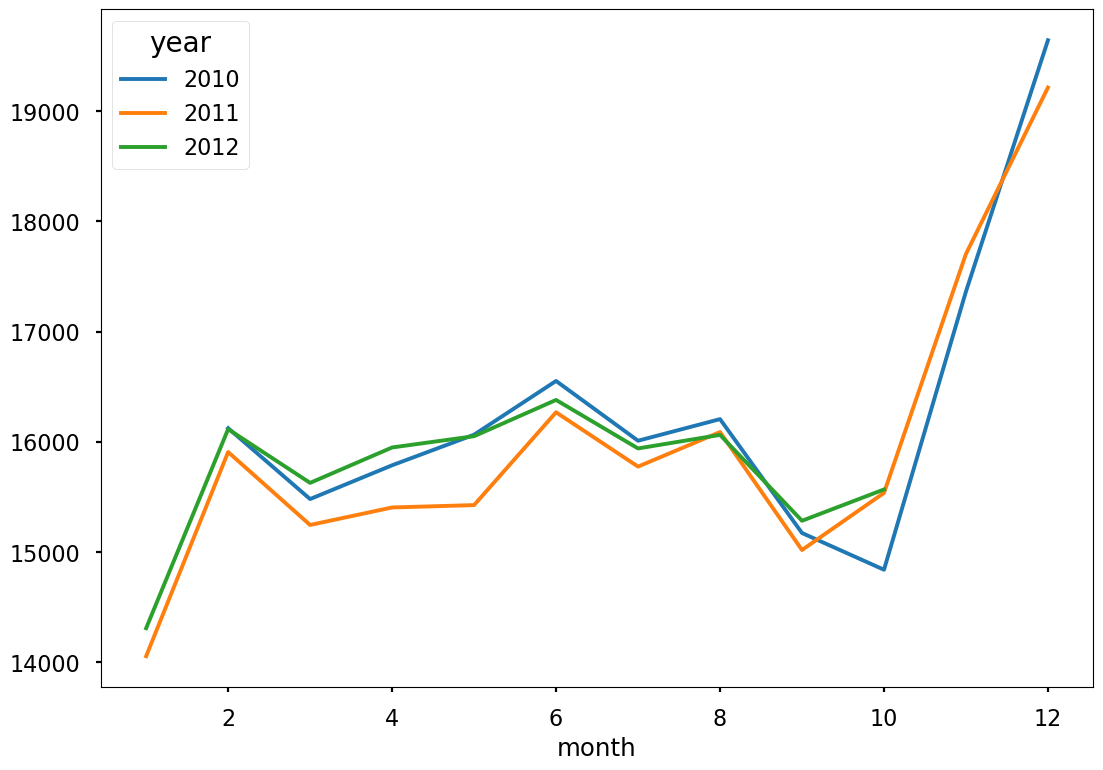

In [62]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

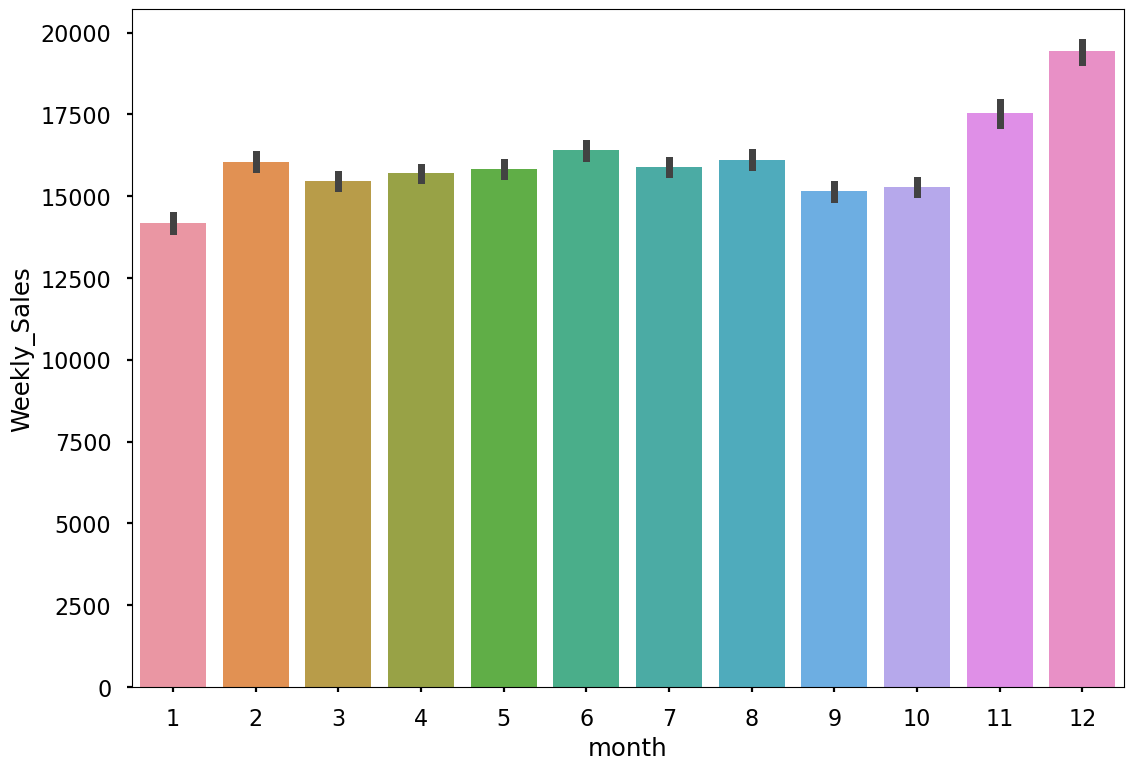

In [63]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

In [64]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='week'>

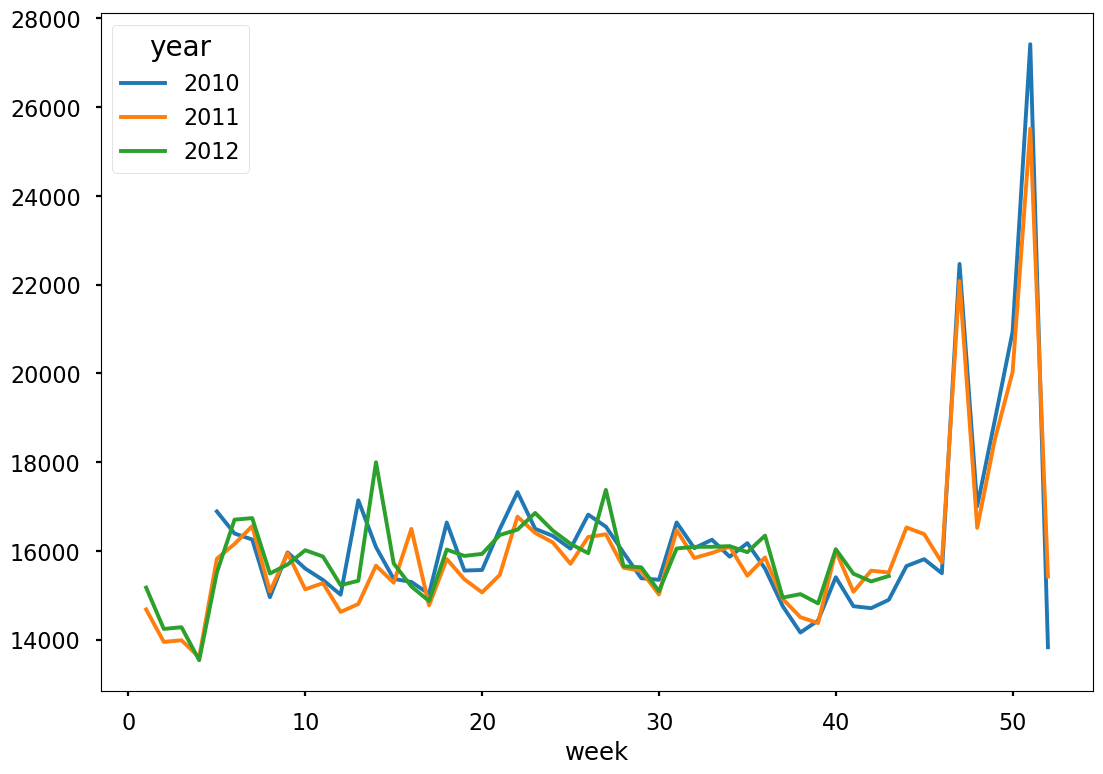

In [65]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

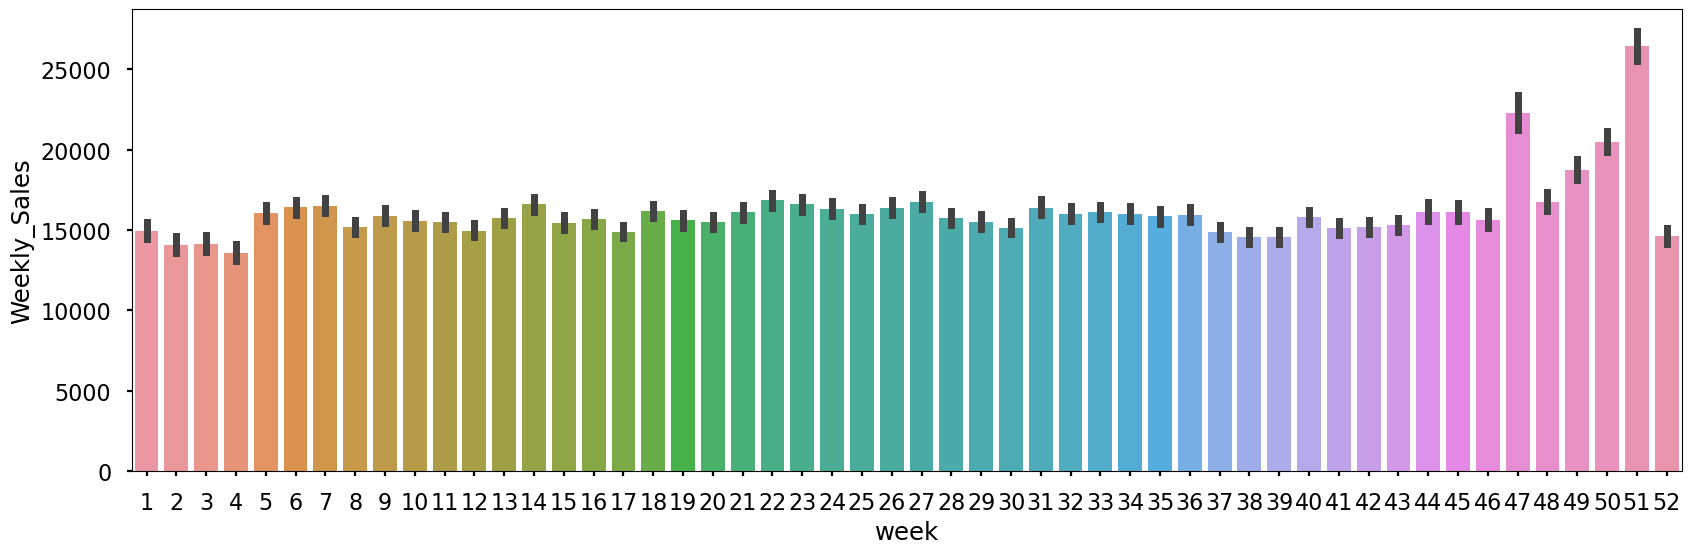

In [66]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

In [67]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price

,Weekly_Sales
Fuel_Price,
2.472,12375.816579
2.513,9654.919556
2.514,15704.146729
2.520,11474.857436
2.533,10268.915476
...,...
4.294,14517.017901
4.301,14258.181950
4.308,16139.939576


<AxesSubplot:xlabel='Fuel_Price'>

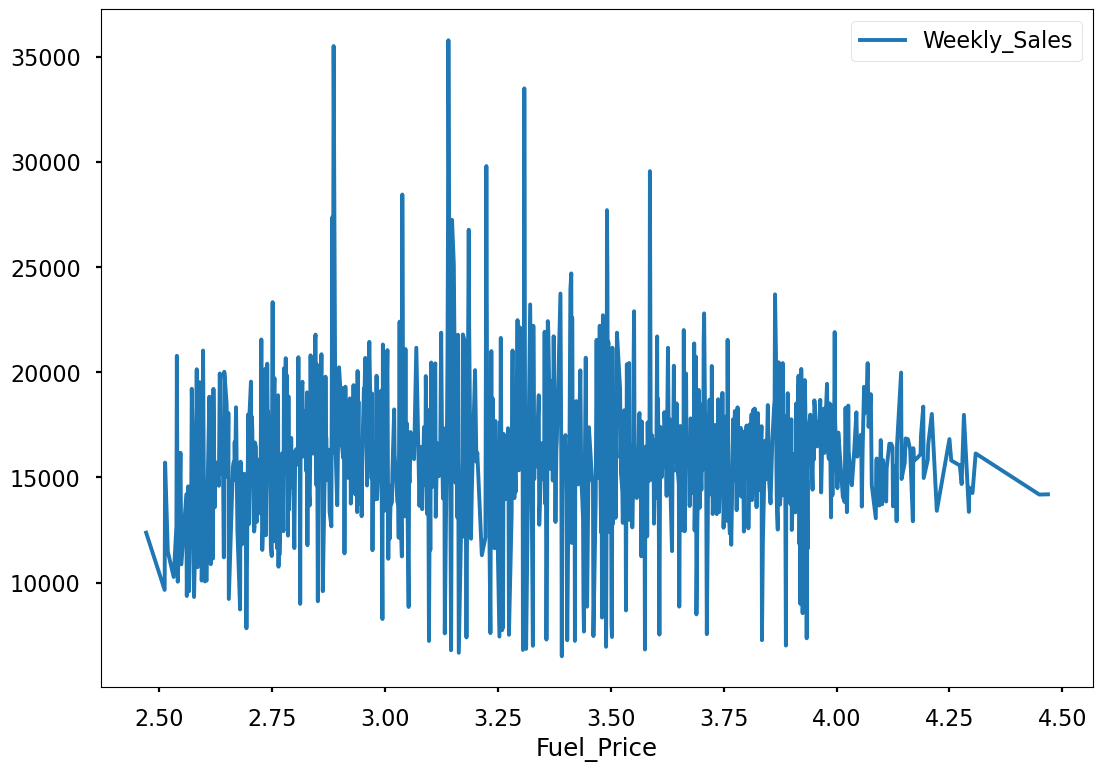

In [68]:

fuel_price.plot()

In [69]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp

,Weekly_Sales
Temperature,
-2.06,8329.033881
5.54,12021.840294
6.23,15927.781029
7.46,8606.890725
9.51,11084.434714
...,...
99.20,5199.964348
99.22,13225.002703
99.66,4939.496250


<AxesSubplot:xlabel='Temperature'>

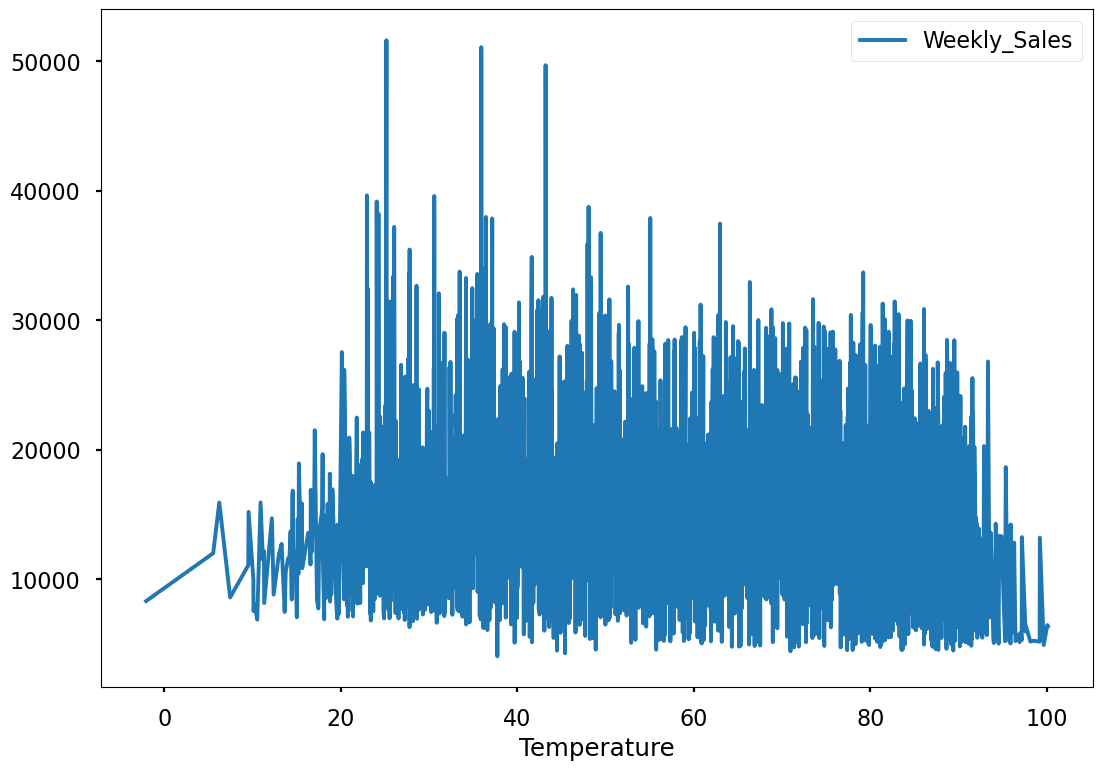

In [70]:
temp.plot()

In [71]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")

<AxesSubplot:xlabel='CPI'>

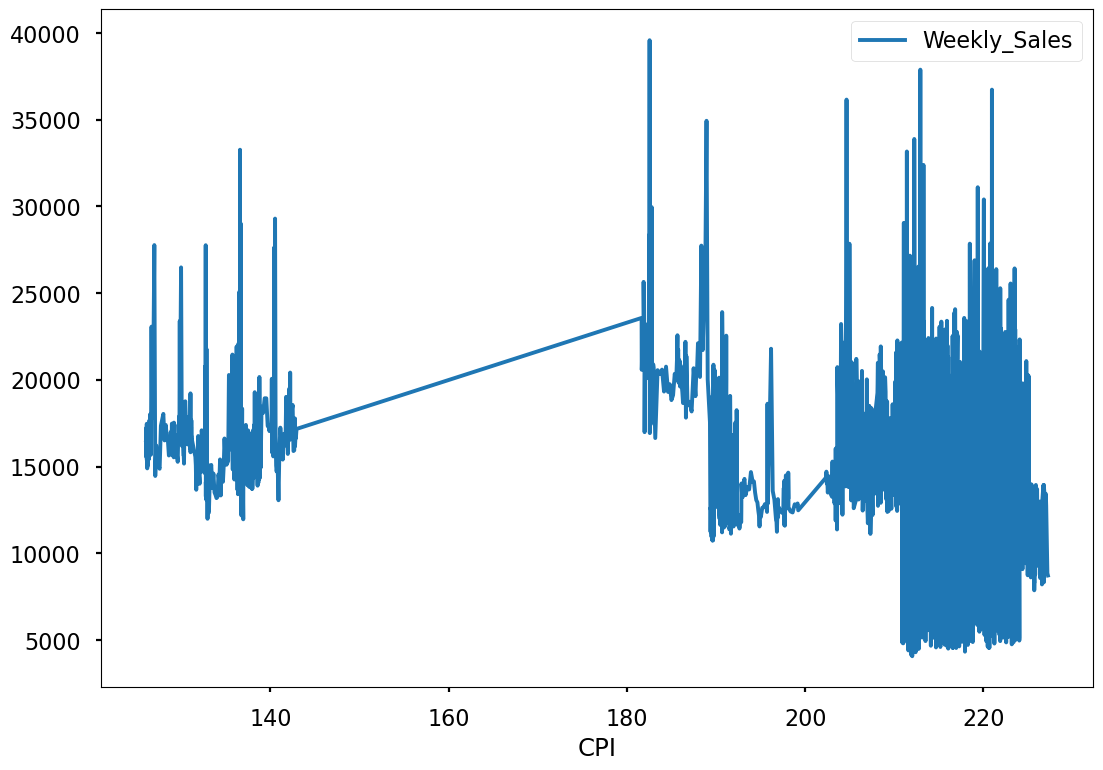

In [72]:
CPI.plot()

In [73]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment

,Weekly_Sales
Unemployment,
3.879,29929.347770
4.077,29634.107100
4.125,17114.420855
4.145,16866.943915
4.156,17392.234785
...,...
13.975,14993.528642
14.021,14293.876902
14.099,14133.220398


<AxesSubplot:xlabel='Unemployment'>

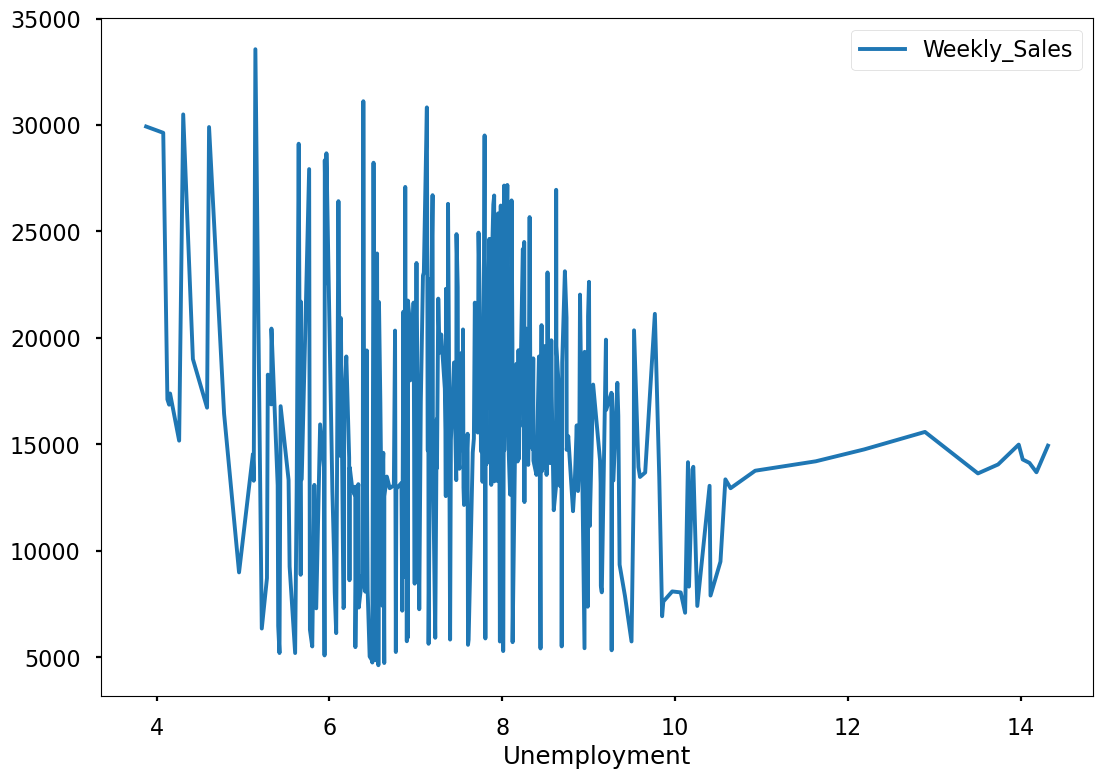

In [74]:
unemployment.plot()

In [75]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

In [76]:
df = pd.read_csv('clean_data.csv')

In [77]:
df.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


In [78]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [79]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Super_Bowl',
       'Labor_Day', 'Thanksgiving', 'Christmas', 'week', 'month', 'year'],
      dtype='object')

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420212 entries, 0 to 420211
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420212 non-null  int64  
 1   Dept          420212 non-null  int64  
 2   Date          420212 non-null  object 
 3   Weekly_Sales  420212 non-null  float64
 4   IsHoliday     420212 non-null  bool   
 5   Temperature   420212 non-null  float64
 6   Fuel_Price    420212 non-null  float64
 7   MarkDown1     420212 non-null  float64
 8   MarkDown2     420212 non-null  float64
 9   MarkDown3     420212 non-null  float64
 10  MarkDown4     420212 non-null  float64
 11  MarkDown5     420212 non-null  float64
 12  CPI           420212 non-null  float64
 13  Unemployment  420212 non-null  float64
 14  Type          420212 non-null  object 
 15  Size          420212 non-null  int64  
 16  Super_Bowl    420212 non-null  bool   
 17  Labor_Day     420212 non-null  bool   
 18  Than

In [81]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

In [82]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [83]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [84]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [85]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [86]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [87]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changining T,F to 0-1

In [88]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [89]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

In [90]:
df_new.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010


In [91]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

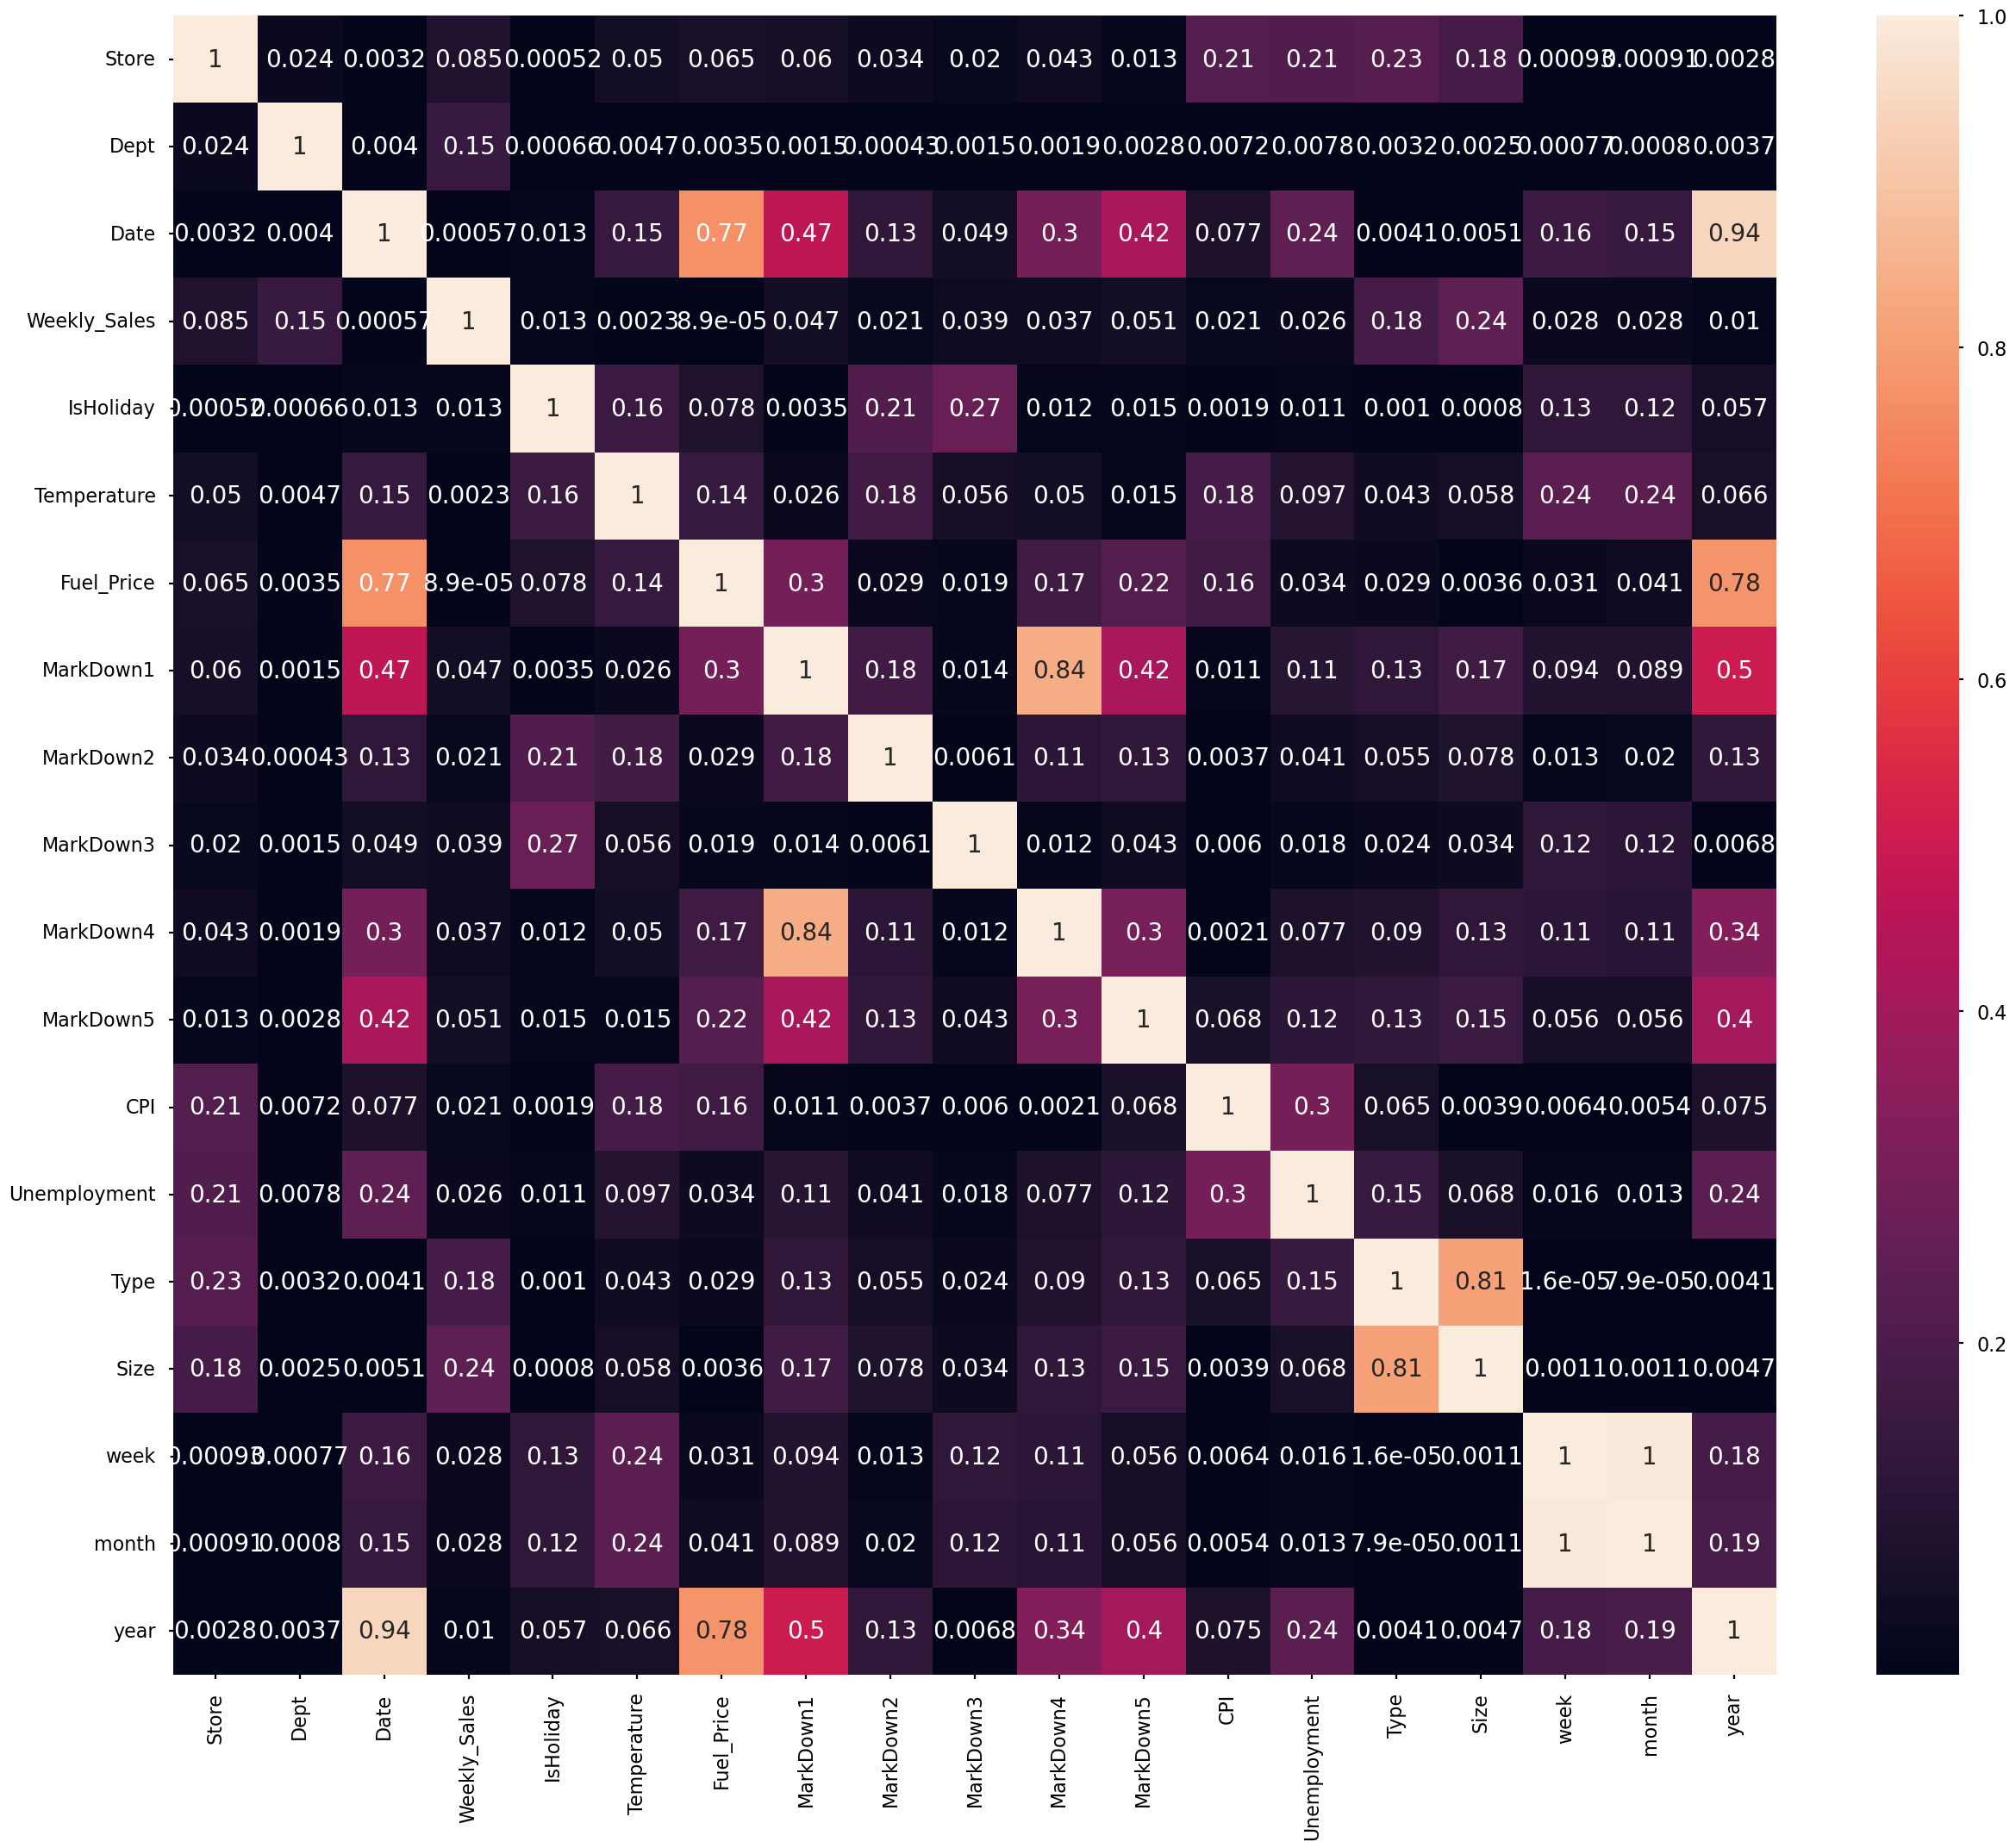

In [92]:
plt.figure(figsize = (30,25))
sns.heatmap(df_new.corr().abs(),annot=True)    # To see the correlations
plt.show()

In [93]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

In [94]:
df_new.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,5,2,2010
329781,35,3,2010-02-05,14612.19,0,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
329782,35,4,2010-02-05,26323.15,0,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
329783,35,5,2010-02-05,36414.63,0,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
329784,35,6,2010-02-05,11437.81,0,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010


In [95]:
# Assuming the target variable is in the 'target_column' column
X = df_new.drop(['Weekly_Sales', 'Date'], axis=1)

y = df_new['Weekly_Sales']

In [96]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
from sklearn.metrics import mean_squared_error, r2_score

In [98]:
# Initialize the model
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35, max_features='sqrt', min_samples_split=10)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 114387843.65
R-squared: 0.78


In [99]:
y_pred

array([ 1903.95152192,  5309.92601493,  6176.74246592, ...,
       10129.98758277, 28543.44496774,  3900.37853665])

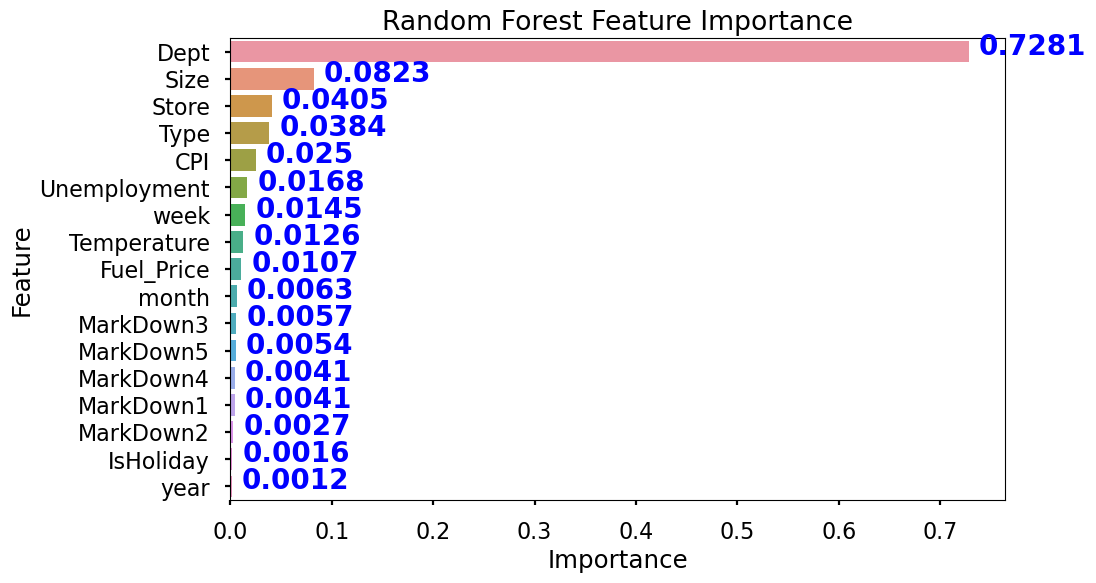

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have already trained the model and calculated feature_importance

# Feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})

# Sort features based on importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plotting with feature names
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)

# Displaying feature names on the bars
for i, v in enumerate(feature_importance['Importance']):
    plt.text(v + 0.01, i + 0.1, str(round(v, 4)), color='blue', fontweight='bold')

plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [101]:
# Assuming you have already trained the model and calculated feature_importance

# Select the top 9 features based on importance
top_features = feature_importance['Feature'][:9]

# Filter the dataset to include only the top features
X_top_features = X[top_features]

# Split the dataset into training and testing sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model_top = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35, max_features='sqrt', min_samples_split=10)

# Train the model using only the top features
rf_model_top.fit(X_train_top, y_train_top)

# Make predictions
y_pred_top = rf_model_top.predict(X_test_top)

# Evaluate the model
mse_top = mean_squared_error(y_test_top, y_pred_top)
r2_top = r2_score(y_test_top, y_pred_top)

print(f'Mean Squared Error (Top Features): {mse_top:.2f}')
print(f'R-squared (Top Features): {r2_top:.2f}')


Mean Squared Error (Top Features): 54542126.09
R-squared (Top Features): 0.89


# Time Series Models

In [116]:
df_new

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,5,2,2010
329781,35,3,2010-02-05,14612.19,0,27.19,2.784,0.00,0.00,0.0,0.00,0.00,135.352461,9.262,2,103681,5,2,2010
329782,35,4,2010-02-05,26323.15,0,27.19,2.784,0.00,0.00,0.0,0.00,0.00,135.352461,9.262,2,103681,5,2,2010
329783,35,5,2010-02-05,36414.63,0,27.19,2.784,0.00,0.00,0.0,0.00,0.00,135.352461,9.262,2,103681,5,2,2010
329784,35,6,2010-02-05,11437.81,0,27.19,2.784,0.00,0.00,0.0,0.00,0.00,135.352461,9.262,2,103681,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329722,34,14,2012-10-26,8930.71,0,57.95,3.514,1151.88,68.01,3.0,392.12,1468.81,131.193097,8.839,1,158114,43,10,2012
329723,34,16,2012-10-26,4841.81,0,57.95,3.514,1151.88,68.01,3.0,392.12,1468.81,131.193097,8.839,1,158114,43,10,2012
329724,34,17,2012-10-26,7035.13,0,57.95,3.514,1151.88,68.01,3.0,392.12,1468.81,131.193097,8.839,1,158114,43,10,2012
329726,34,20,2012-10-26,2124.60,0,57.95,3.514,1151.88,68.01,3.0,392.12,1468.81,131.193097,8.839,1,158114,43,10,2012


In [117]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420212 entries, 0 to 420211
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         420212 non-null  int64         
 1   Dept          420212 non-null  int64         
 2   Date          420212 non-null  datetime64[ns]
 3   Weekly_Sales  420212 non-null  float64       
 4   IsHoliday     420212 non-null  int32         
 5   Temperature   420212 non-null  float64       
 6   Fuel_Price    420212 non-null  float64       
 7   MarkDown1     420212 non-null  float64       
 8   MarkDown2     420212 non-null  float64       
 9   MarkDown3     420212 non-null  float64       
 10  MarkDown4     420212 non-null  float64       
 11  MarkDown5     420212 non-null  float64       
 12  CPI           420212 non-null  float64       
 13  Unemployment  420212 non-null  float64       
 14  Type          420212 non-null  int64         
 15  Size          420212 n

In [118]:
df_new.set_index('Date', inplace=True) #seting date as index

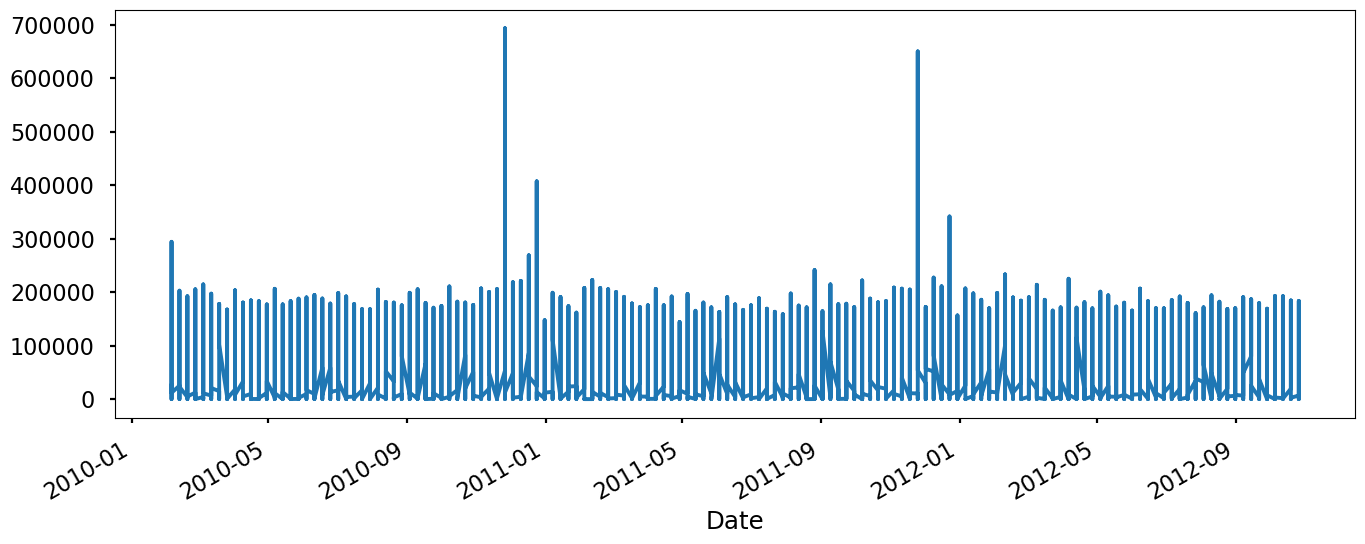

In [119]:
plt.figure(figsize=(16,6))
df_new['Weekly_Sales'].plot()
plt.show()

In [120]:
df_new_week = df_new.resample('W').mean() #resample data as weekly

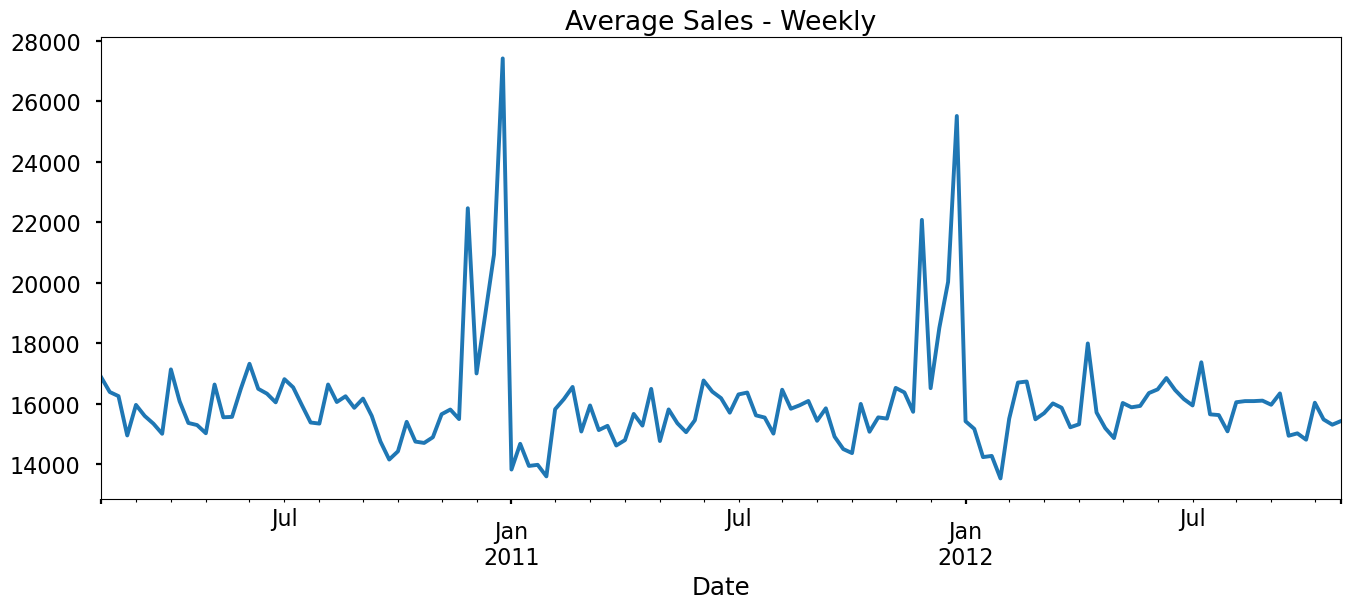

In [121]:
plt.figure(figsize=(16,6))
df_new_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [122]:
df_new_month = df_new.resample('MS').mean() # resampling as monthly


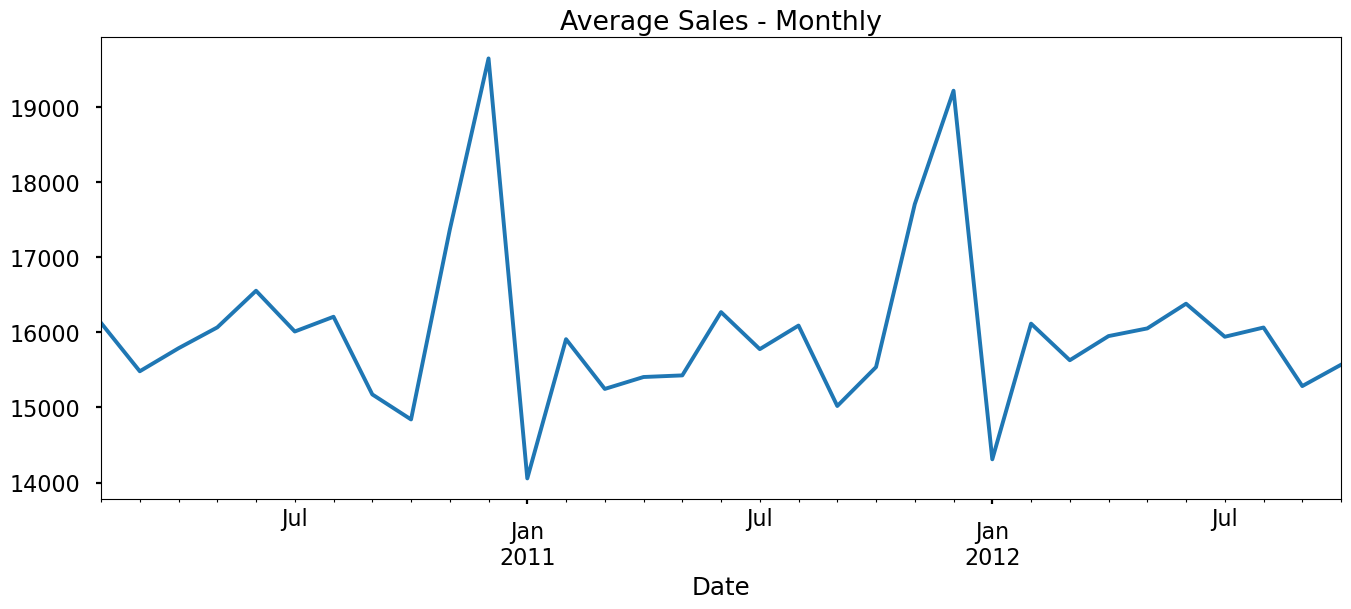

In [123]:
plt.figure(figsize=(16,6))
df_new_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

In [124]:
# finding 2-weeks rolling mean and std
roll_mean = df_new_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_new_week['Weekly_Sales'].rolling(window=2, center=False).std()

In [125]:
roll_mean

Date
2010-02-07             NaN
2010-02-14    16639.257187
2010-02-21    16323.049089
2010-02-28    15605.559082
2010-03-07    15460.376717
                  ...     
2012-09-30    14920.503157
2012-10-07    15426.531650
2012-10-14    15761.069187
2012-10-21    15398.005372
2012-10-28    15372.427778
Freq: W-SUN, Name: Weekly_Sales, Length: 143, dtype: float64

In [126]:
roll_std

Date
2010-02-07           NaN
2010-02-14    351.212838
2010-02-21     95.972943
2010-02-28    918.711155
2010-03-07    713.392286
                 ...    
2012-09-30    148.325593
2012-10-07    863.957950
2012-10-14    390.850427
2012-10-21    122.599345
2012-10-28     86.427166
Freq: W-SUN, Name: Weekly_Sales, Length: 143, dtype: float64

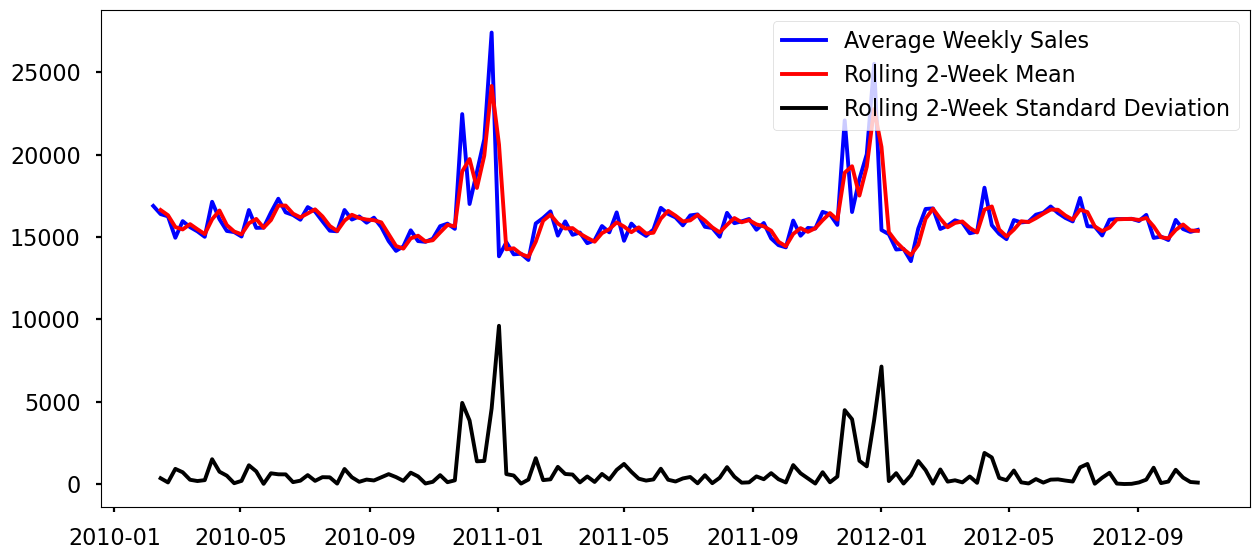

In [127]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_new_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

In [128]:
adfuller(df_new_week['Weekly_Sales'])

(-5.927107223737573,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

In [130]:
train_data = df_new_week[:int(0.7*(len(df_new_week)))] 
test_data = df_new_week[int(0.7*(len(df_new_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 18)
Test: (43, 18)


In [131]:
target = "Weekly_Sales"
used_cols = [c for c in df_new_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

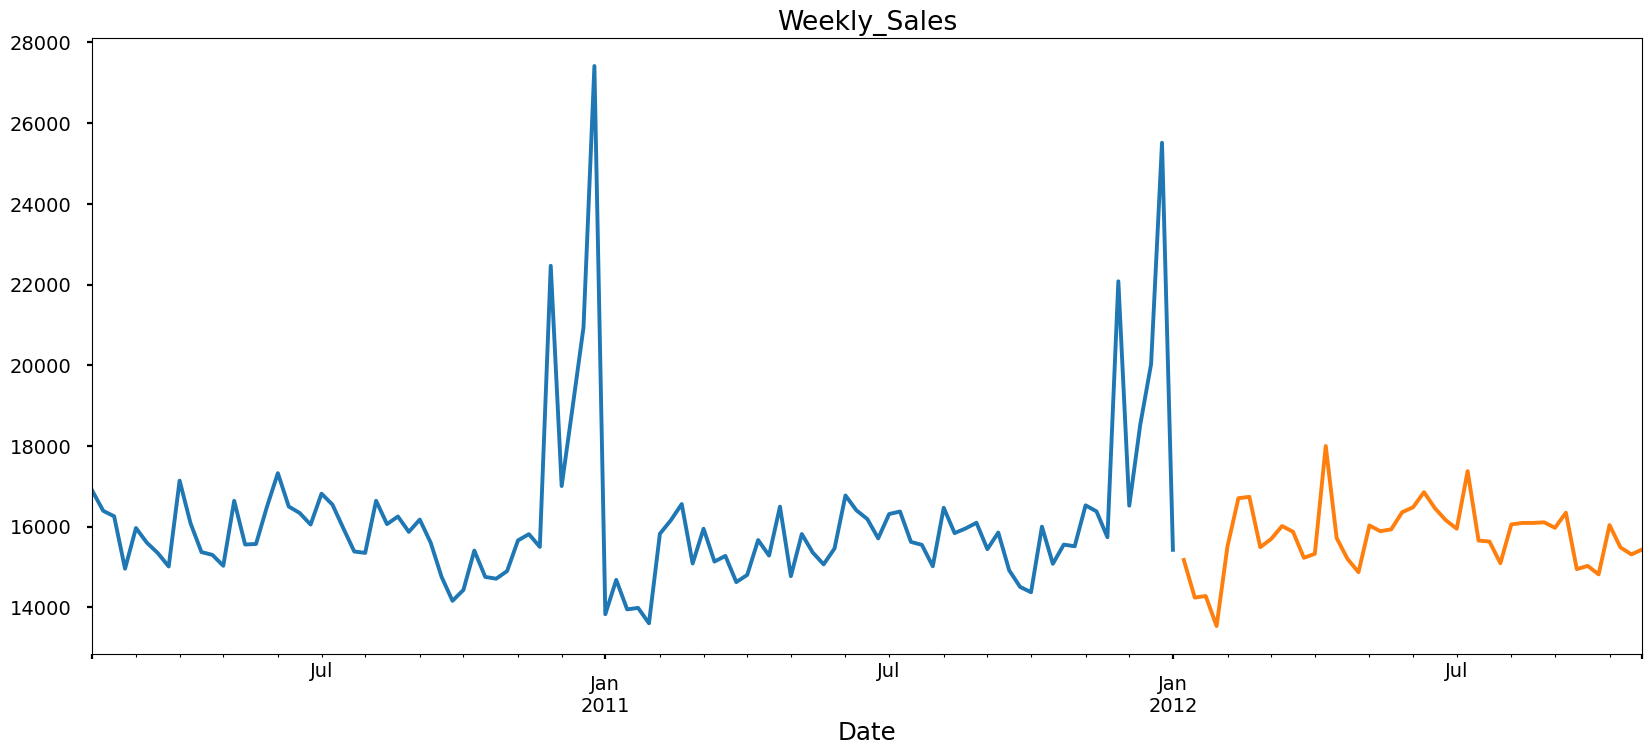

In [132]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [136]:
decomposed = decompose(df_new_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 

In [137]:
decomposed 

decomposed(x=array([16887.60216565, 16390.91220753, 16255.1859697 , 14955.93219388,
       15964.82123978, 15600.14990489, 15344.28083902, 15011.76309524,
       17139.43991162, 16083.35019015, 15368.60635714, 15299.0944015 ,
       15029.58878267, 16639.25365009, 15555.98710021, 15569.44466529,
       16490.94393301, 17324.39337245, 16497.64538806, 16336.94380446,
       16050.02743457, 16816.07200756, 16545.67815889, 15957.1994755 ,
       15383.53189513, 15347.95544704, 16639.71462893, 16060.98440373,
       16250.57462707, 15869.41330453, 16173.69926662, 15601.85253333,
       14754.02428425, 14159.42210544, 14431.17103177, 15405.76667691,
       14752.61861197, 14708.59198429, 14896.92140417, 15657.41577633,
       15812.44450806, 15496.83184753, 22464.57892833, 17005.32868825,
       18953.98026217, 20935.08901118, 27415.84898374, 13828.57059508,
       14679.58732327, 13948.50856653, 13985.16006536, 13603.70199244,
       15822.2868495 , 16155.91020478, 16558.86970088, 15085.818

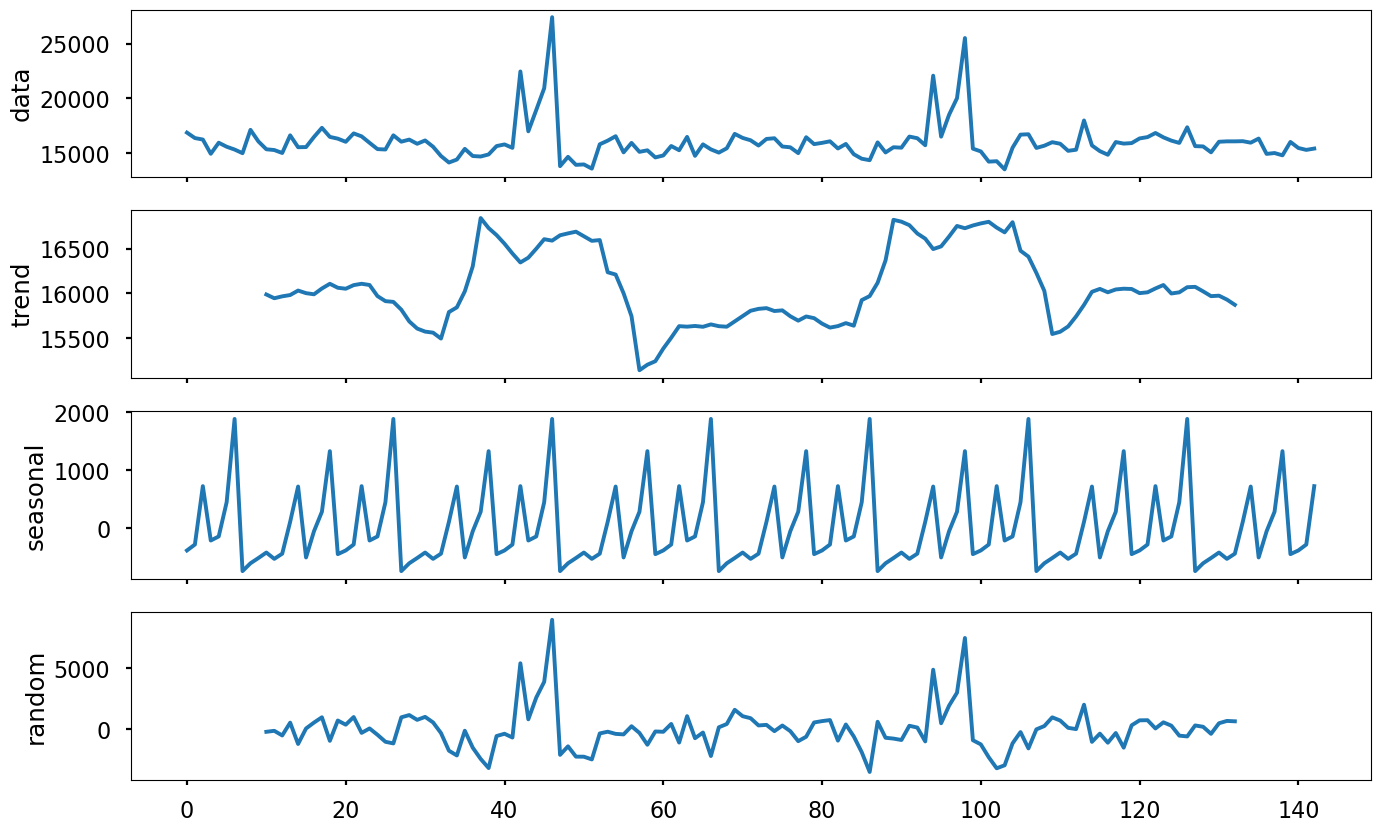

In [138]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

In [139]:
df_week_diff = df_new_week['Weekly_Sales'].diff().dropna() #creating difference values

In [140]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

In [141]:
diff_roll_mean

Date
2010-02-14           NaN
2010-02-21   -316.208098
2010-02-28   -717.490007
2010-03-07   -145.182365
2010-03-14    322.108856
                 ...    
2012-09-30    -65.473980
2012-10-07    506.028492
2012-10-14    334.537538
2012-10-21   -363.063816
2012-10-28    -25.577593
Freq: W-SUN, Name: Weekly_Sales, Length: 142, dtype: float64

In [142]:
diff_roll_std

Date
2010-02-14            NaN
2010-02-21     255.239894
2010-02-28     822.738212
2010-03-07    1632.103441
2010-03-14     971.253860
                 ...     
2012-09-30     204.056996
2012-10-07    1012.283543
2012-10-14    1254.808377
2012-10-21     268.251082
2012-10-28     209.026511
Freq: W-SUN, Name: Weekly_Sales, Length: 142, dtype: float64

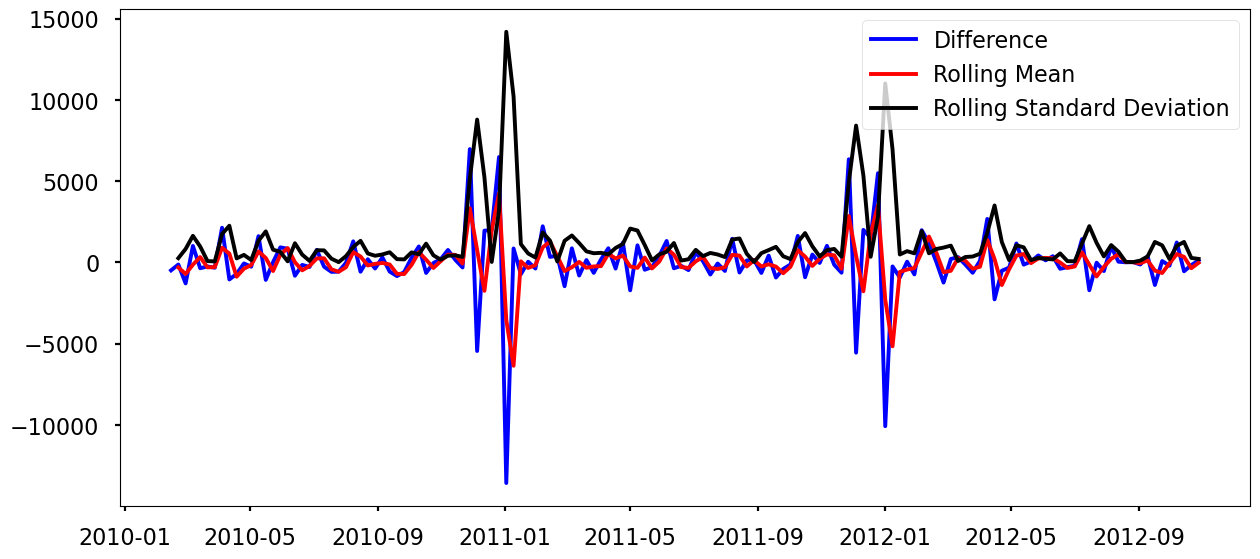

In [143]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [144]:
df_week_lag = df_new_week['Weekly_Sales'].shift().dropna() #shifting the data 

In [145]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

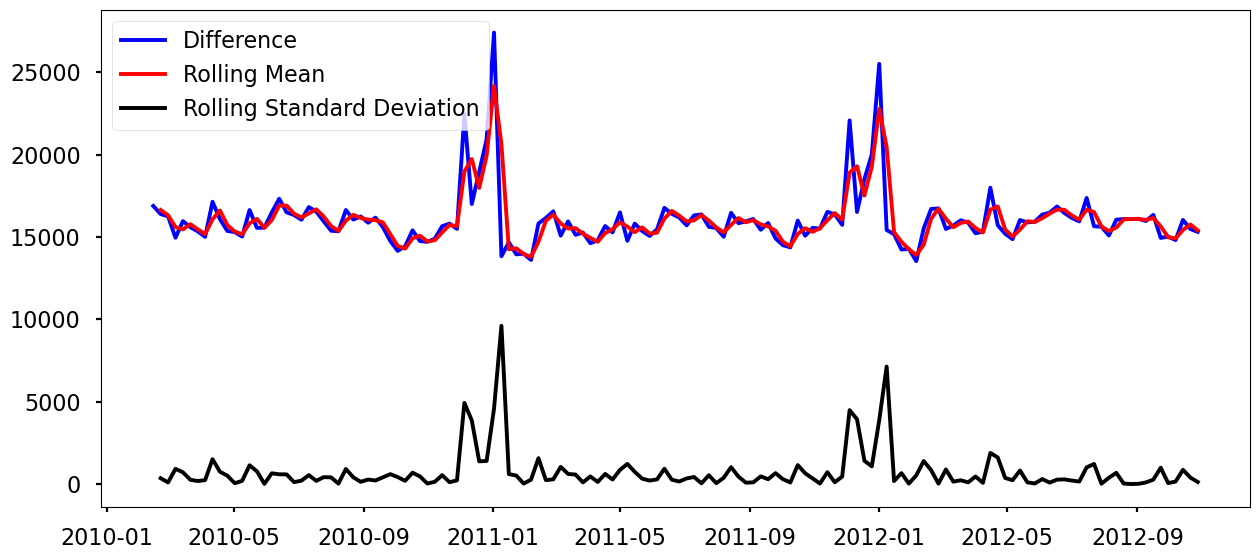

In [146]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [147]:
logged_week = np.log1p(df_new_week['Weekly_Sales']).dropna() #taking log of data

In [148]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

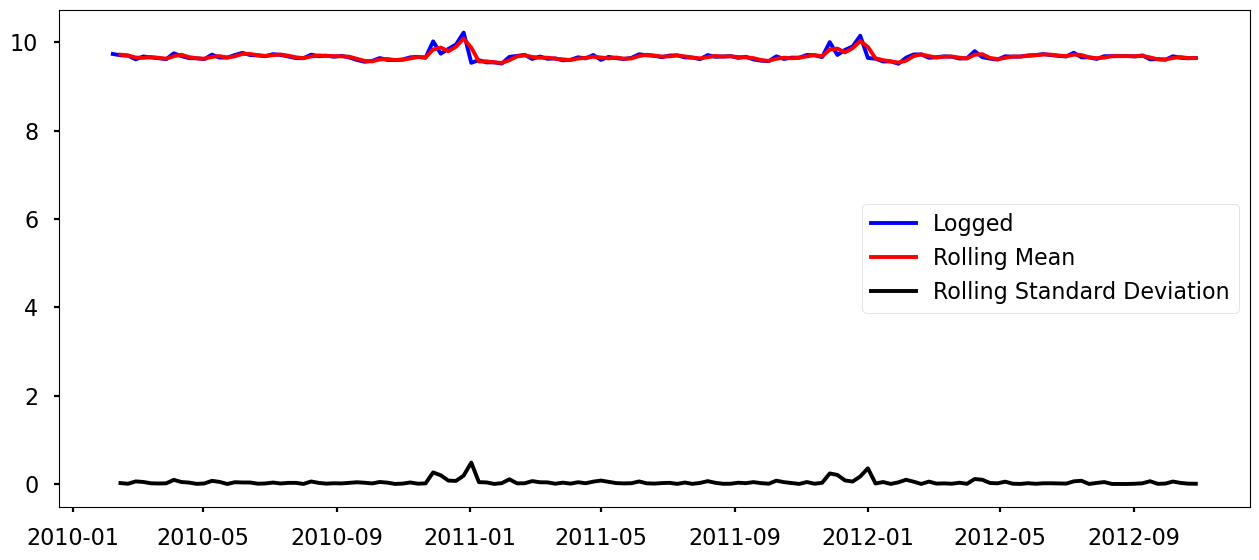

In [149]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [150]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [151]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.32 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

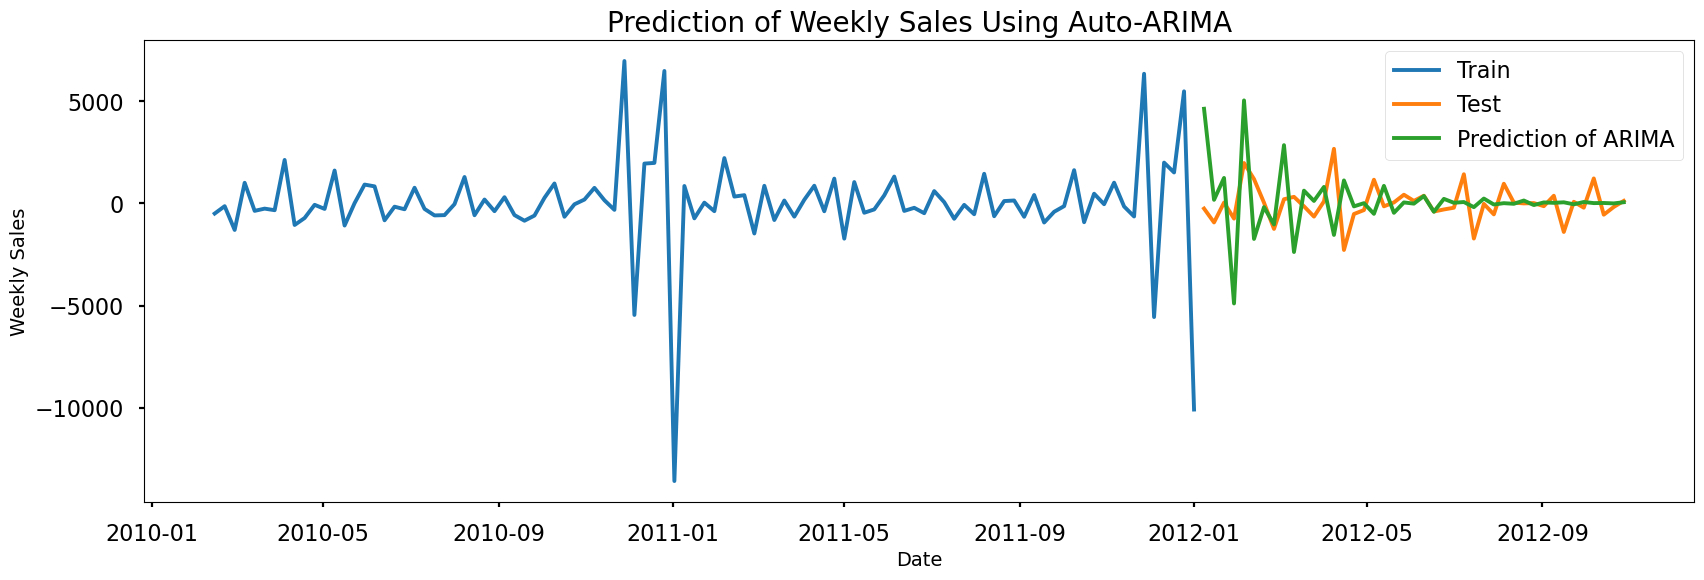

In [152]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


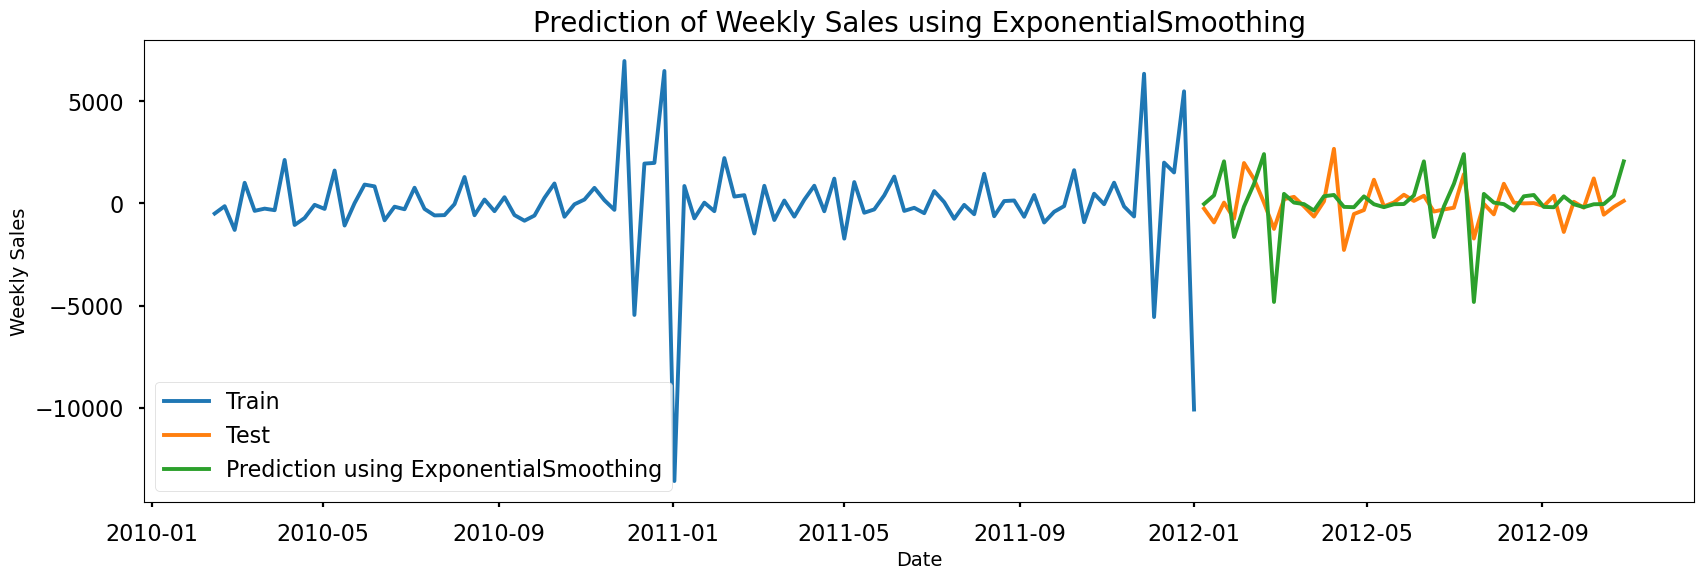

In [153]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [155]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [156]:
wmae_test(test_data_diff, y_pred)

840.681060966696